# 【第３回 課題4　解答シート】画像変換(1) : Pix2Pix
解答用のシートです．解答はこちらを改変して行って下さい．　

In [2]:
# UEC 共通設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0,..., "7":GPU7 を使用

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else:
    datadir="/usr/local/class/object/media/"

if '/yanai/' in cdir:
    datadir="/export/space/yanai/media/"
print(datadir)

/usr/local/class/object/media/


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
# This code is based on https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division
import scipy

import keras
from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import time
import matplotlib.pyplot as plt
import sys
from data_loader_px import DataLoader
import numpy as np
import os

In [20]:
img_size = 128
food = "ebichill"

img_shape = (img_size, img_size, 3)
data_loader = DataLoader(datadir=datadir+"foodimg"+str(img_size),
                         dataset_name=food,img_res=(img_size,img_size))

outdir='result/pix2pix_1'
os.makedirs(outdir, exist_ok=True)

epochs=50
batch_size=64
sample_interval=200

In [21]:
# EncoderDecoder ネットワークの定義

def build_generator():
    """U-Net Generator"""
    
    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d
    
    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8)
    u4 = deconv2d(u3, d3, gf*4)
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)
    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    
    return Model(d0, output_img)

In [7]:
def build_discriminator():

    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)

    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([img_A, img_B], validity)

In [22]:
# Calculate output shape of D (PatchGAN)
patch = int(img_size / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])

#generator = build_generator()
generator = load_model('%s/pix2pix_gen_edge2%s.h5' % (outdir,food))
# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)
# By conditioning on B generate a fake version of A
fake_A = generator(img_B)
# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],loss_weights=[1, 100],optimizer=optimizer)


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def sample_images(epoch, batch_i):
    #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
    r, c = 3, 5

    imgs_A, imgs_B = data_loader.load_data(batch_size=5, is_testing=True)
    fake_A = generator.predict(imgs_B)
    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Input', 'Generated', 'Original']
    fig, axs = plt.subplots(r, c, figsize=(10,6))
    cnt = 0
    for i in range(r):
       for j in range(c):
           axs[i,j].imshow(gen_imgs[cnt])
           axs[i,j].set_title(titles[i])
           axs[i,j].axis('off')
           cnt += 1
    fig.savefig("%s/%d_%d.png" % (outdir, epoch, batch_i))
    
    display.clear_output(wait = True)
    display.display(fig)
    plt.close()

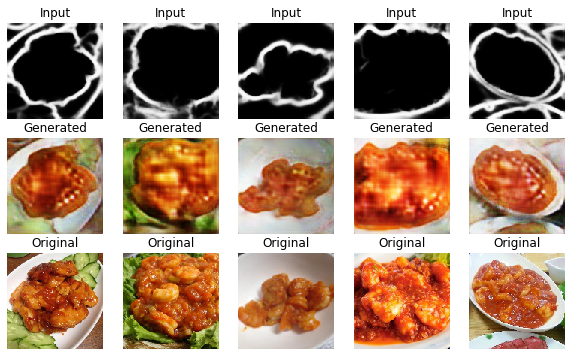

[Epoch 49/50] [Batch 5/15] [D loss: 0.005503, acc: 100%] [G loss: 8.221391] time: 685.5258030891418
[Epoch 49/50] [Batch 10/15] [D loss: 0.003452, acc: 100%] [G loss: 7.976857] time: 690.2762587070465


In [42]:
# training loop

start = time.time()

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

for epoch in range(epochs):
    for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch(batch_size)):
        # train discreminator
        # Condition on B and generate a translated version
        fake_A = generator.predict(imgs_B)
        # Train the discriminators (original images = real / generated = Fake)
        d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
        d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  train Generator
        g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

        tm = time.time() - start
        # Plot the progress
        if batch_i % 5==0:
           print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0], tm))

         # If at save interval => save generated image samples
        if batch_i % sample_interval == 0:
            sample_images(epoch, batch_i)

In [34]:
generator.save('%s/pix2pix_gen_edge2%s.h5' % (outdir,food))
print("saved the models as '%s/pix2pix_gen_edge2%s.h5'" % (outdir,food))

saved the models as 'result/pix2pix_1/pix2pix_gen_edge2ebichill.h5'


## 課題4

以下の小問の(1)(2)を解答せよ．

1. 23種類の中から好きな料理を選んでエッジ画像からの食事画像生成モデルを学習してみよ．128x128で30分くらい掛かる．
1. 学習できたモデルを用いて，マウスで輪郭線画像を5枚書いて変換してみよ．変換方法は，以下のコードを利用せよ．できるだけ学習に使ったエッジ画像と似ている雰囲気で手書き画像を作成するとうまく生成できるはずである．

# (1) 23種類の中から好きな料理を選んでエッジ画像からの食事画像生成モデルを学習してみよ．128x128で30分くらい掛かる

# コメント
最終段階になってもそれっぽい画像は生成できるが、そのものは生成できるようにならなかった。$128\times 128$の画像かつ30分もかけてこれなのだから、自分が普段扱う写真のサイズ(縦横のおおよその数字)である256くらいだとすると、単純計算で4倍の時間がかかることになる。しかも一種類の写真の生成でこれなのだから、画像生成がいかに難しいか(時間がかかるか)がわかった。今回の学習結果が鮮明になっていない理由も、G-lossが原因であると考えられる。今回は10周ほど学習させたが、ロス値が約10のまま下がらなかった。1でも正解から大幅にずれるのに10もずれているのだから、学習結果の画像は妥当なものになっていると考えられる。

# (2)学習できたモデルを用いて，マウスで輪郭線画像を5枚書いて変換してみよ．変換方法は，以下のコードを利用せよ．できるだけ学習に使ったエッジ画像と似ている雰囲気で手書き画像を作成するとうまく生成できるはずである．

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


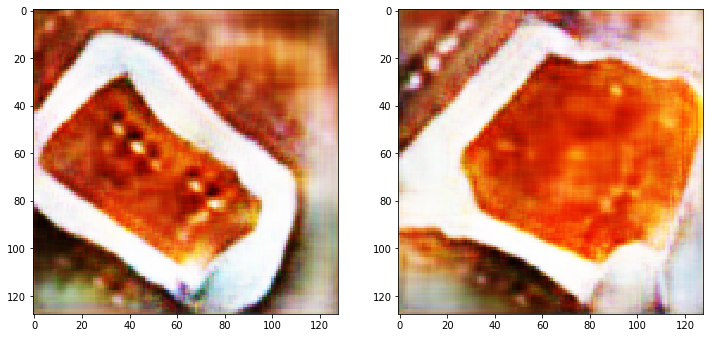

In [35]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('%s/pix2pix_gen_edge2%s.h5' % (outdir,food))

img21=np.array(Image.open('img/test7.png').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/test2.png').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


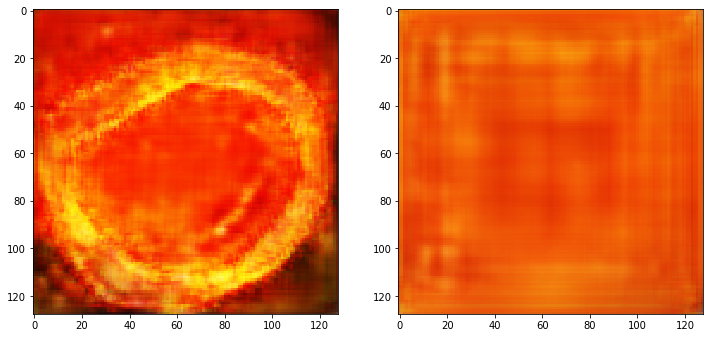

In [36]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('%s/pix2pix_gen_edge2%s.h5' % (outdir,food))

img21=np.array(Image.open('img/test3.png').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/test4.png').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


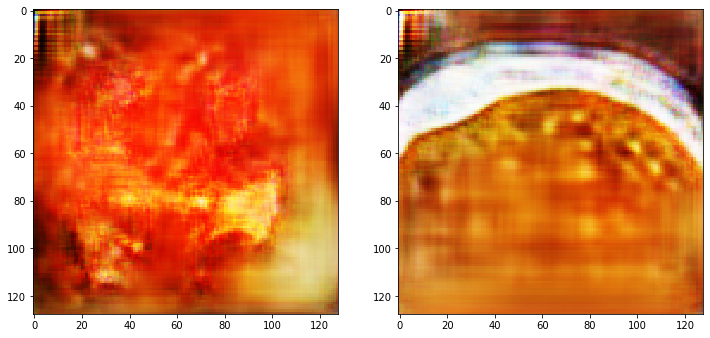

In [37]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model

generator=load_model('%s/pix2pix_gen_edge2%s.h5' % (outdir,food))

img21=np.array(Image.open('img/test5.png').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/test6.png').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

(1, 128, 128, 3) (1, 128, 128, 3)
(2, 128, 128, 3)
(2, 128, 128, 3) (2, 128, 128, 3)


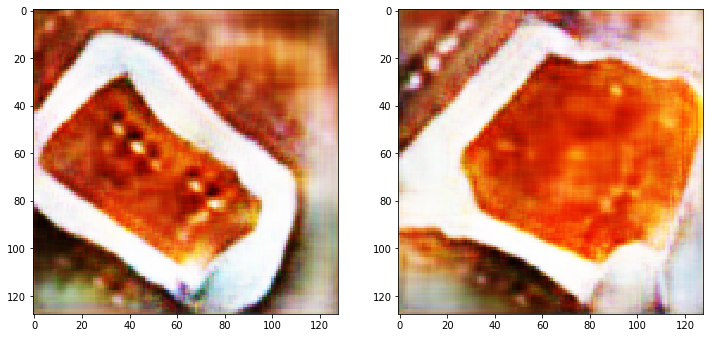

In [6]:
from skimage import feature,filters
from PIL import Image
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.models import load_model
import numpy as np
img_size = 128
outdir = 'result/pix2pix_1'
food = 'ebichill'
generator=load_model('%s/pix2pix_gen_edge2%s.h5' % (outdir,food))

img21=np.array(Image.open('img/test7.png').convert("RGB").resize((img_size,img_size)))
img22=np.array(Image.open('img/test2.png').convert("RGB").resize((img_size,img_size)))
#img22=np.array(Image.open(datadir+'foodimg'+str(img_size)+'/%s/hed0000.png' % food).convert("RGB").resize((128,128)))
img21=img21[np.newaxis,...]
img22=img22[np.newaxis,...]
print(img21.shape,img22.shape)
img2=np.vstack((img21,img22))
img2=np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out=generator.predict(img2)
print(img2.shape,out.shape)
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
# Rescale images 0 - 1
out = 0.5 * out + 0.5 
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(out[0])
plt.subplot(122)
plt.imshow(out[1])
plt.show()

# コメント
何となくエビチリっぽいものは確認できるが、全然エビチリには見えないものができた。ただ、元々のモデルによる生成画像も似たようなものなので、生成自体はうまくいっているのだと考えられる。線が一定の太さを保っていないと本来皿を想定していた範囲に、おそらくエビであると予測されるが、よくわからない黄色い物体が生成されてしまう。(test3,test4)

In [ ]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()